<h1>Dimensionality Reduction</h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display, HTML, Markdown


from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.random_projection import GaussianRandomProjection as GRP , SparseRandomProjection as RCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix,f1_score, confusion_matrix,classification_report,accuracy_score,roc_auc_score,recall_score,mean_squared_error


from scipy.stats import kurtosis

from scipy.linalg import pinv
from scipy import sparse 

from itertools import product
from collections import defaultdict
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

<h3>Import and Clean Data</h3>

In [2]:
#Heart Data
data = pd.read_csv('../data/heartFailurePrediction/heart.csv', sep=',')

#handling cholestrol 0
data['Cholesterol'] = data['Cholesterol'].replace(0, data['Cholesterol'].mean())

#scale data
# Select numerical variables
data_X = data.drop("HeartDisease", axis=1)
# data_X = data_X.drop("Id", axis=1)
numeric = data_X.select_dtypes(exclude=object).columns
nonnumeric = data_X.select_dtypes(include=object).columns
#numeric.remove('quality')
print(type(numeric))
for col in numeric:
    data_X[col] = StandardScaler().fit_transform(data_X[[col]])

data = data_X.join(data['HeartDisease'])

# Dealing with the outliers (RestingBP)
q1 = data['RestingBP'].quantile(0.25)
q3 = data['RestingBP'].quantile(0.75)
iqr = q3-q1
Lower_tail = q1 - 1.5 * iqr
Upper_tail = q3 + 1.5 * iqr

# Median imputation (RestingBP)
med = np.median(data['RestingBP'])
for i in data['RestingBP']:
    if i > Upper_tail or i < Lower_tail:
            data['RestingBP'] = data['RestingBP'].replace(i, med)

# Dealing with outliers (Cholesterol)
q1 = data['Cholesterol'].quantile(0.25)
q3 = data['Cholesterol'].quantile(0.75)
iqr = q3-q1
Lower_tail = q1 - 1.5 * iqr
Upper_tail = q3 + 1.5 * iqr

# Median imputation (Cholesterol) just on upper tail
med = np.median(data['Cholesterol'])
for i in data['Cholesterol']:
    if i > Upper_tail:
        data['Cholesterol'] = data['Cholesterol'].replace(i, med)

# Select numerical variables
objList = data.select_dtypes(include=object).columns

le = LabelEncoder()
for feat in objList:
    data[feat] = le.fit_transform(data[feat].astype(str))
    
#below vars are used.
data_H = data
heartX=data_H.drop("HeartDisease", 1).copy().values
hearty=data_H[["HeartDisease"]]

<class 'pandas.core.indexes.base.Index'>


In [3]:
#Wine Data
data = pd.read_csv('../data/wineQualityDataset/WineQT.csv', sep=',')
#Drop id
data = data.drop("Id", axis=1)
#drop duplicate
data = data.drop_duplicates().reset_index(drop=True)

data = data.drop(data[data.quality == 3].index).reset_index(drop=True)
data = data.drop(data[data.quality == 4].index).reset_index(drop=True)
#data = data.drop(data[data.quality == 8].index).reset_index(drop=True)
data.loc[data["quality"] == 8, "quality"] = 7

#normalize the data
# Select numerical variables
data_X = data.drop("quality", axis=1)
# data_X = data_X.drop("Id", axis=1)
numeric = data_X.select_dtypes(exclude=object).columns
#numeric.remove('quality')
print(type(numeric))
for col in numeric:
    data_X[col] = StandardScaler().fit_transform(data_X[[col]])

data = data_X.join(data['quality'])

#update y values
data.loc[data["quality"] == 5, "quality"] = 0
data.loc[data["quality"] == 6, "quality"] = 1
data.loc[data["quality"] == 7, "quality"] = 2

#below vars are used.
data_W = data
wineX=data_W.drop("quality", 1).copy().values
winey= data_W[["quality"]]

<class 'pandas.core.indexes.base.Index'>


In [4]:
# stratified sampling Heart Disease
from sklearn.model_selection import StratifiedShuffleSplit

print("Splitting StratifiedShuffleSplit into train/test")

split = StratifiedShuffleSplit(n_splits=1 , test_size=0.3, random_state=15)
for train_ind, test_ind in split.split(data_H, data_H["HeartDisease"]):
    train_set = data_H.loc[train_ind]
    test_set = data_H.loc[test_ind]

heart_Train = train_set
yH_train = train_set[["HeartDisease"]]
XH_train = train_set.drop("HeartDisease", axis=1)
yH_test = test_set[["HeartDisease"]]
XH_test = test_set.drop("HeartDisease", axis=1)

split = StratifiedShuffleSplit(n_splits=1 , test_size=0.3, random_state=15)
for train_ind, test_ind in split.split(data_W, data_W["quality"]):
    train_set = data_W.loc[train_ind]
    test_set = data_W.loc[test_ind]

wine_Train = train_set
yW_train = train_set[["quality"]]
XW_train = train_set.drop("quality", axis=1)
yW_test = test_set[["quality"]]
XW_test = test_set.drop("quality", axis=1)


Splitting StratifiedShuffleSplit into train/test


<h3>Helper Methods</h3>

In [5]:
def reconstruction_error(algo, data):
    W = algo.components_
    if sparse.issparse(W):
        W = W.todense()
    p = pinv(W)
    reconstructed = ((p @ W) @ (data.T)).T
    errors = np.square(data - reconstructed)
    return np.nanmean(errors)

def plot_explained_varaince(pca, n):
    ax = sns.barplot(
    x=np.arange(1,n+1,1), 
    y=pca.explained_variance_[:n],
    color='salmon'
    )
#     var = np.cumsum(pca.explained_variance_[:n])
#     plt.plot(np.arange(1,n+1,1), var, label="Cumulative Exp Variance")
    ax.set(xlabel='Clusters', ylabel='Explained variance')
    ax.set_title('Explained variance')
    fig = ax.get_figure()
    plt.show()

def calc_pca_components(data, dataName):
    t0 = time()
    pca = PCA(n_components=data.shape[1], random_state=33)
    pca.fit(data)
    var = np.cumsum(pca.explained_variance_ratio_*100)
    
    end = time() - t0
    
    plt.title('PCA Analysis for %s' % dataName)
    plt.ylabel('Cumulative % Variance')
    plt.xlabel('Number of Features')
    plt.axhline(y=95, color='gray', linestyle='--', label='95% Variance')
    plt.plot(range(1,data.shape[1]+1), var, label="Cumulative Variance")
    plt.plot(range(1,data.shape[1]+1), (pca.explained_variance_ratio_*100), label="Variance")
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
    
    numComponents = np.argmax(var>95) + 1
    
    
    print('%s total features: %d' %(dataName, data.shape[1]))
    print('Best Number of PCA Components: %d' % numComponents)
    print('Total Time: %.3f seconds' % end)
    
    return numComponents
    
    
#
# ICA
#
def calc_ica_components(data, dataName):
    t0 = time()
    
    dimensions = data.shape[1]+1
    kurtosis = []
    for dim in range(2,dimensions):
        ica = FastICA(n_components=dim, max_iter=600, random_state=33)
        res = ica.fit_transform(data)
        tmp = pd.DataFrame(res)
        k   = tmp.kurt(axis=0)
        kurtosis.append(k.abs().mean())
        
    end = time() - t0
    print(kurtosis)
    optimalComponents = np.argmax(kurtosis)
    
    plt.title('ICA Analysis for %s' % dataName)
    plt.ylabel('Kurtosis')
    plt.xlabel('Number of Features')
    plt.plot(range(2,dimensions), kurtosis)
    plt.grid()
    plt.show()
    
    print('Total Number of Features:', data.shape[1])
    print('Best Number of ICA Components:', optimalComponents+1)
    print('Total Time: %.3f seconds' % end)
    
    return optimalComponents


def plot_ica_meanKurtosiss(data, dataName):
    dimensions = data.shape[1]+1
    i_kurt = []
    for i in range(2,dimensions):
        ica = FastICA(n_components=i, max_iter=600, random_state=33, whiten=True)
        data_reduced = ica.fit_transform(data)
        kur = kurtosis(data_reduced)
        i_kurt.append(np.mean(abs(kur)))
        
    plt.figure(figsize=(7, 4))
    
#     (
#     x=np.arange(1,n+1,1), 
#     y=pca.explained_variance_[:n],
#     color='salmon'
#     )
    
    ax = sns.barplot(
    x=np.arange(2,dimensions,1), 
    y=i_kurt,
    color='salmon'
    )
    ax.set(xlabel='Clusters', ylabel='Mean Kurtosis')
    ax.set_title('ICA Kurtosis distribution for %s'  % dataName)
    fig = ax.get_figure()
    plt.show()

    
#
# RP
#
def calc_rp_components(data, dataName, tries=100):
    t0 = time()
    
    dimensions = data.shape[1]+1
    kurtosis = []
    stddev_kurtosis = []
    lowerbound = []
    upperbound = []
    for dim in range(2,dimensions):
        kurts = []
        for t in range(tries):
            rp = GRP(n_components=dim, random_state=33)
            res = rp.fit_transform(data)
            tmp = pd.DataFrame(res)
            k   = tmp.kurt(axis=0)
            kurts.append(k.abs().mean())
        kurtosis.append(np.mean(kurts))
        lowerbound.append(np.mean(kurts)-np.std(kurts))
        upperbound.append(np.mean(kurts)+np.std(kurts))
        
    optimalComponents = np.argmax(kurtosis)
    
    end = time() - t0
    
    plt.title('RP Analysis for %s: %d Iterations' % (dataName, tries))
    plt.ylabel('Kurtosis')
    plt.xlabel('Number of Features')
    plt.plot(range(2,dimensions), kurtosis)
    plt.fill_between(range(2, dimensions), lowerbound, upperbound, facecolor='gray', alpha=0.1)
    plt.grid()
    plt.show()
    
    print('Total Number of Features:', data.shape[1])
    print('Best Number of RP Components:', optimalComponents+2)
    print('Total Time: %.3f seconds' % end)
#     print(kurtosis)
    
    return optimalComponents+2



def plot_rca_meanKurtosiss(data, dataName, tries=100):
    dimensions = data.shape[1]+1
    kurtosis = []
    for dim in range(2,dimensions):
        kurts = []
        for t in range(tries):
            rp = GRP(n_components=dim, random_state=33)
            res = rp.fit_transform(data)
            tmp = pd.DataFrame(res)
            k   = tmp.kurt(axis=0)
            kurts.append(k.abs().mean())
        kurtosis.append(np.mean(kurts))

        
    plt.figure(figsize=(7, 4))
#     print(kurtosis)
    ax = sns.barplot(
    x=np.arange(2,dimensions,1), 
    y=kurtosis,
    color='salmon'
    )
    ax.set(xlabel='Clusters', ylabel='Mean Kurtosis')
    ax.set_title('RCA RP Kurtosis distribution for %s: %d Iterations'  % (dataName, tries))
    fig = ax.get_figure()
    plt.show()

#
# ETC
#

def calc_ETC_model(dataX,datay,cols, dataName):
    t0 = time()
    etc = ExtraTreesClassifier(n_estimators = 100)
    etc = etc.fit(dataX,datay)   
    end = time() - t0

    plt.figure(figsize=(7, 4))

    ax = sns.barplot(
    x=cols, 
    y=list(etc.feature_importances_),
    color='salmon')
    ax.set(xlabel='Feature', ylabel='Importance')
    ax.set_title('ETC Analysis for %s' % dataName)
    fig = ax.get_figure()
    plt.xticks(rotation = 45)
    plt.show()
    print('%s total features: %d' %(dataName, dataX.shape[1]))
    print('Total Time: %.3f seconds' % end)
    
    return etc

#https://towardsdatascience.com/selecting-optimal-k-for-k-means-clustering-c7579fd2e926
def model_report_multiclass(model,
                            X_train,
                            y_train,
                            X_test,
                            y_test,
                            show_train_report=True,
                            show_test_report=True,
                            fitted_model=False,
                            cmap=['cool', 'copper_r'],
                            normalize='true',
                            figsize=(15, 5)):
    """
    Dispalys model report of multiclass classification model.
    Report of model performance using train-test split dataset.
    Shows train and test score, Confusion Matrix and, ROC Curve of performane of test data. 
    Uses sklearn and yellowbrick for plotting.
    
    Parameters:
    -----------
    model : object, scikit-learn model object; no default.
    X_train : pandas.DataFrame, predictor variable training data split; no default,
    y_train : pandas.DataFrame, target variable training data split; no default,
    X_test : pandas.DataFrame, predictor variable test data split; no default,
    y_test : pandas.DataFrame, target variable test data split; no default,
    cmap : {NOT IMPLIMENTED} list of str, colormap of Confusion Matrix; default: ['cool', 'copper_r'],
        cmap of train and test data
    normalize : {NOT IMPLIMENTED} str, normalize count of Confusion Matrix; default: 'true',
        - `true` to normalize counts.
        - `false` to show raw counts.
    figsize : tuple ``(lenght, height) in inchs``, figsize of output; default: (16, 6),
    show_train_report : boolean; default: False,
        - True, to show report.
        - False, to turn off report.
    fitted_model : bool; default: False,
        - if True, fits model to train data and generates report.
        - if False, does not fits model and generates report.
        Use False for previously fitted model.
    ---version 0.9.14---
    """
    if fitted_model is False:
        model.fit(X_train, y_train)
    train = model.score(X_train, y_train)
    test = model.score(X_test, y_test)

    def str_model_(model):
        """Helper function to get model class display statement, this text conversion breaks code if 
        performed in ``model_report`` function's local space. This function is to isolate from the 
        previous function's local space."""
        str_model = str(model.__class__).split('.')[-1][:-2]
        display(
            HTML(
                f"""<strong>Report of {str_model} type model using train-test split dataset.</strong>"""
            ))

    str_model_(model)
    print(f"{'*'*90}")
    print(f"""Train accuracy score: {train.round(4)}""")
    print(f"""Test accuracy score: {test.round(4)}""")
    if abs(train - test) <= .05:
        print(
            f"    No over or underfitting detected, diffrence of scores did not cross 5% thresh hold."
        )
    elif (train - test) > .05:
        print(
            f"    Possible Overfitting, diffrence of scores {round(abs(train-test)*100,2)}% crossed 5% thresh hold."
        )
    elif (train - test) < -.05:
        print(
            f"    Possible Underfitting, diffrence of scores {round(abs(train-test)*100,2)}% crossed 5% thresh hold."
        )
    print(f"{'*'*90}")
    print("")

def get_Dumy_classifierReport(X,y):
    X_feat_imp = X
    y_feat_imp = y
    X_feat_imp_train, X_feat_imp_test, y_feat_imp_train, y_feat_imp_test = train_test_split(
        X_feat_imp, y_feat_imp, train_size=.8)
    # Random Forest
    clf_rf = RandomForestClassifier(
        n_jobs=-1,
        criterion='entropy',
        min_samples_leaf=5,
        min_samples_split=6,
        class_weight='balanced_subsample',
    )
    model_report_multiclass(clf_rf,
                           X_feat_imp_train,
                           y_feat_imp_train,
                           X_feat_imp_test,
                           y_feat_imp_test,
                           show_train_report=True)

In [6]:


def run_RCA(X,y,title):
    
    dims = list(np.arange(2,(X.shape[1]-1),3))
    dims.append(X.shape[1])
    tmp = defaultdict(dict)

    for i,dim in product(range(5),dims):
        rp = RCA(random_state=i, n_components=dim)
        tmp[dim][i] = pairwiseDistCorr(rp.fit_transform(X), X)
    tmp = pd.DataFrame(tmp).T
    mean_recon = tmp.mean(axis=1).tolist()
    std_recon = tmp.std(axis=1).tolist()


    fig, ax1 = plt.subplots()
    ax1.plot(dims,mean_recon, 'b-')
    ax1.set_xlabel('Random Components')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Mean Reconstruction Correlation', color='b')
    ax1.tick_params('y', colors='b')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(dims,std_recon, 'm-')
    ax2.set_ylabel('STD Reconstruction Correlation', color='m')
    ax2.tick_params('y', colors='m')
    plt.grid(False)

    plt.title("Random Components for 5 Restarts: "+ title)
    fig.tight_layout()
    plt.show()
    
def pairwiseDistCorr(X1,X2):
    assert X1.shape[0] == X2.shape[0]
    
    d1 = pairwise_distances(X1)
    d2 = pairwise_distances(X2)
    return np.corrcoef(d1.ravel(),d2.ravel())[0,1]

def rmse_ICA(data, title):
    dimensions = data.shape[1]+1
    rc_errors_wine = {}
    
    for dim in range(2,dimensions):
        ica = FastICA(n_components=dim, random_state=33)
        x_prime = ica.fit_transform(data.values)
    
        # reconstruction
        A = np.linalg.pinv(ica.components_.T)
        reconstructed = np.dot(x_prime, A)
        rc_err = mean_squared_error(data.values, reconstructed)    
        rc_errors_wine[dim] = rc_err
#     print(dim, ": ", rc_err)
    plt.figure()
    plt.title("RMSE error ICA: "+ title)
    plt.plot(list(rc_errors_wine.keys()), list(rc_errors_wine.values()))
    plt.xlabel("dimension")
    plt.ylabel("RMSE")
    plt.show()
    
    
def rmse_RCA_GAUSS(data, title):
    dimensions = data.shape[1]+1
    rc_errors_wine = {}
    for dim in range(2,dimensions):
        grp = GRP(n_components=dim, random_state=33)
        x_prime = grp.fit_transform(data.values)
    
        # reconstruction
        A = np.linalg.pinv(grp.components_.T)
        reconstructed = np.dot(x_prime, A)
        rc_err = mean_squared_error(data.values, reconstructed)    
        rc_errors_wine[dim] = rc_err
#     print(dim, ": ", rc_err)
    plt.figure()
    plt.plot(list(rc_errors_wine.keys()), list(rc_errors_wine.values()))
    plt.xlabel("dimension")
    plt.ylabel("RMSE")
    plt.show()
    
def dummy_NN_RecallScore_train(X,y):
    clf_nn = MLPClassifier(random_state=42)
    start_time = time()
    clf_nn.fit(X, y)
    
    end_time = time()- start_time
    print('Train Time: %.3f seconds' % end_time)
    start_time = time()
    y_pred = clf_nn.predict(X)
    end_time = time()- start_time
    print('Test Time: %.3f seconds' % end_time)
    nn_accuracy = recall_score(y, y_pred)
    print('Recall Score of NN is %.2f%%' % (nn_accuracy * 100))
def dummy_NN_f1Score_train(X,y):
    clf_nn = MLPClassifier(random_state=42)
    start_time = time()
    clf_nn.fit(X, y)
    
    end_time = time()- start_time
    print('Train Time: %.3f seconds' % end_time)
    start_time = time()
    y_pred = clf_nn.predict(X)
    end_time = time()- start_time
    print('Test Time: %.3f seconds' % end_time)
    nn_accuracy = f1_score(y, y_pred, average='micro')
    print('f1_micro Score of NN is %.2f%%' % (nn_accuracy * 100))

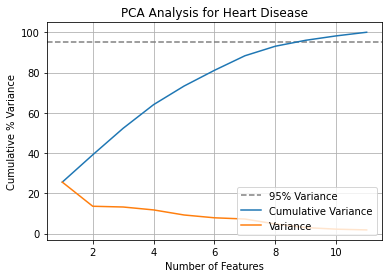

Heart Disease total features: 11
Best Number of PCA Components: 9
Total Time: 0.002 seconds
PCA Reconstruction Error:  0.013210414852908383


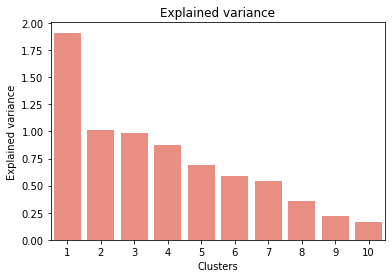

In [7]:
#
# PCA
#
b_pca_heart_c = calc_pca_components(XH_train, "Heart Disease")
b_pca_heart = PCA(n_components=10, random_state=33).fit(XH_train)
b_pca_r_err = reconstruction_error(b_pca_heart, heartX)
print('PCA Reconstruction Error: ', b_pca_r_err)
plot_explained_varaince(b_pca_heart, 10)



In [8]:
heart_Train.reset_index(drop=True, inplace=True)
comp = 9
pca = PCA(n_components=comp, random_state=42)
pca_result = pca.fit_transform(XH_train)
for i in range(comp):
    field_name = "pca-"+str(i)
    heart_Train[field_name] = pca_result[:,i]
#     heart_dataset[field_name] = pca_result[:,i]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
sum(pca.explained_variance_ratio_)
heartX_pca = pca_result

Explained variation per principal component: [0.25549299 0.13560858 0.13188637 0.11741448 0.09224694 0.07825897
 0.07224205 0.04740908 0.0295752 ]


In [59]:
hist_pca = pd.concat([pd.DataFrame(heartX_pca), yH_train], axis=1)
hist_pca.head()

0         1         2         3         4         5         6  \
0 -0.728567  0.701284 -1.306816 -0.603123 -0.214709 -0.737843  0.389423   
1  0.350189 -0.659246  0.117795 -1.513630 -0.281890  2.143099  1.336332   
2  1.820095 -1.531183 -0.440016 -0.286485 -1.046534  0.696210  0.028351   
3 -1.081586 -0.263890  0.186387 -0.571927 -0.411414  0.092422 -0.787847   
4  1.262155  1.735661 -0.189048  0.889994  0.151104 -0.329770  0.410202   

          7         8  HeartDisease  
0 -0.698998 -0.348048           NaN  
1  0.096777  0.566491           1.0  
2  0.777363  0.010665           NaN  
3  0.723798 -0.359572           1.0  
4 -0.600357  0.110210           0.0

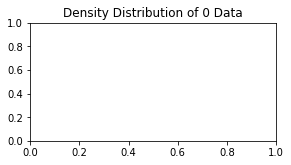

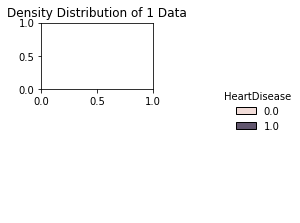

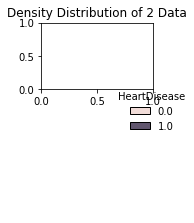

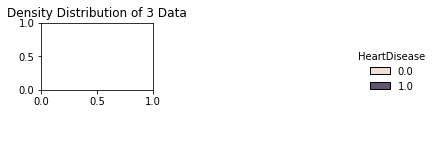

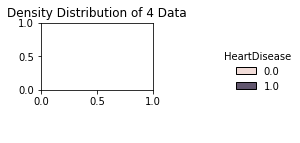

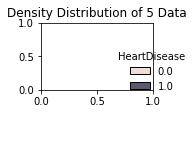

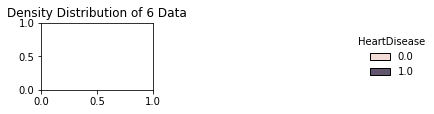

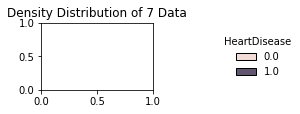

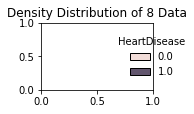

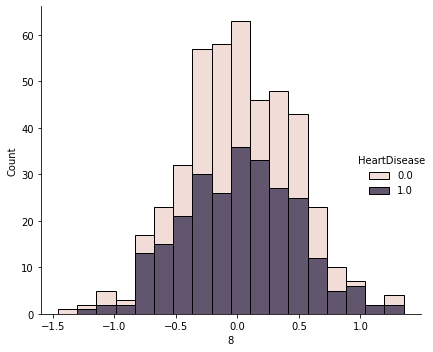

In [60]:
hist_pca = pd.concat([pd.DataFrame(heartX_pca), yH_train], axis=1)
plt.figure(figsize=(15,10))
for i,col in enumerate(pd.DataFrame(heartX_pca).columns,1):
    plt.subplot(4,3,i)
    plt.title(f"Density Distribution of {col} Data")
    sns.displot(pd.DataFrame(hist_pca), x=col, hue="HeartDisease", multiple="stack")
#     sns.histplot(heartX_pca[col],kde=True)
    plt.tight_layout()
    plt.plot()

<AxesSubplot:xlabel='pca-0', ylabel='pca-1'>

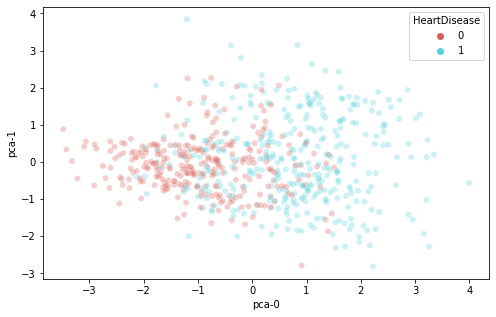

In [10]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="pca-0", y="pca-1",
    hue="HeartDisease",
    palette=sns.color_palette("hls", 2),
    data=heart_Train,
    legend="full",
    alpha=0.3
)

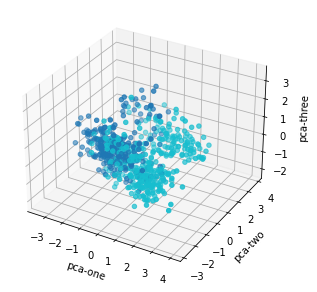

In [11]:
rndperm = np.random.permutation(heart_Train.shape[0])
ax = plt.figure(figsize=(8,5)).gca(projection='3d')
ax.scatter(
    xs=heart_Train.loc[rndperm,:]["pca-0"], 
    ys=heart_Train.loc[rndperm,:]["pca-1"], 
    zs=heart_Train.loc[rndperm,:]["pca-2"], 
    c=heart_Train.loc[rndperm,:]["HeartDisease"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [12]:

fig = px.scatter_3d(heart_Train,
                    x='pca-0',
                    y='pca-1',
                    z='pca-2',
                    color='HeartDisease',
                    title='Heart PCA 3 visualization',
#                     template='plotly_dark',
                    color_discrete_sequence=px.colors.qualitative.Antique)
fig.update_traces(marker=dict(size=2))
fig.update_layout(width=700, height=500, bargap=0.05)
fig.show()

In [13]:
# Choose the number of components that capture 85% of the variance
n1 = 9
# Transform the data
pca1 = PCA(n_components=n1, random_state=42)
XH_transform = pca1.fit_transform(XH_train)

XH_inverse = pca1.inverse_transform(XH_transform)
mse1 = np.sum(np.square(XH_train - XH_inverse))/XH_inverse.size
print('MSE for dataset 1: ', mse1)

rc_err = mean_squared_error(XH_train, XH_inverse) 
print('MSE- ', rc_err)

print( '------ Baseline Dummy -----')
dummy_NN_RecallScore_train(XH_train, yH_train)
print( '------ Heart PCA Dummy -----')
dummy_NN_RecallScore_train(XH_transform, yH_train)

MSE for dataset 1:  Age               0.000023
Sex               0.013422
ChestPainType     0.000168
RestingBP         0.000040
Cholesterol       0.000099
FastingBS         0.000023
RestingECG        0.000051
MaxHR             0.000142
ExerciseAngina    0.011224
Oldpeak           0.000047
ST_Slope          0.001827
dtype: float64
MSE-  0.027066559609700936
------ Baseline Dummy -----
Train Time: 0.885 seconds
Test Time: 0.003 seconds
Recall Score of NN is 93.52%
------ Heart PCA Dummy -----
Train Time: 0.914 seconds
Test Time: 0.002 seconds
Recall Score of NN is 90.99%


[0.429889775359541, 0.45531575152431625, 0.5249505748334495, 0.6046795559528243, 0.48036394714789754, 0.5516693129362424, 0.5839183526313536, 0.5903680244804536, 0.5803628018605129, 0.6929560748055675]


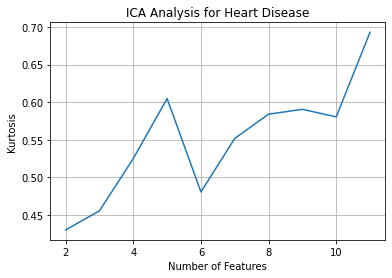

Total Number of Features: 11
Best Number of ICA Components: 10
Total Time: 2.294 seconds
ICA Reconstruction Error:  0.013210414852908364


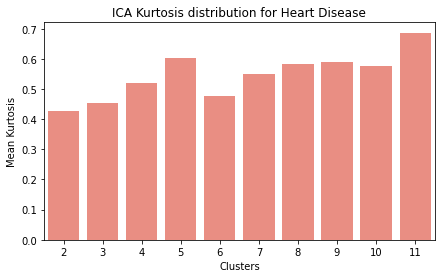

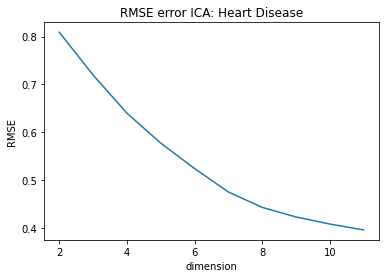

In [14]:
#
# ICA
#
b_ica_heart_c = calc_ica_components(XH_train, "Heart Disease")
b_ica_heart = FastICA(n_components=10, random_state=33).fit(XH_train)
b_ica_r_err = reconstruction_error(b_ica_heart, heartX)
print('ICA Reconstruction Error: ', b_ica_r_err)
plot_ica_meanKurtosiss(XH_train, "Heart Disease")

rmse_ICA(XH_train, "Heart Disease")



In [15]:
# Choose the number of components that capture 85% of the variance
comp = 10
ica = FastICA(n_components=comp, random_state=33, max_iter=1000)
XH_transform = ica.fit_transform(XH_train)

XH_inverse = ica.inverse_transform(XH_transform)
mse1 = np.sum(np.square(XH_train - XH_inverse))/XH_inverse.size
print('MSE for dataset 1: ', mse1)
rc_err = mean_squared_error(XH_train, XH_inverse) 
print('MSE- ', rc_err)

MSE for dataset 1:  Age               9.587600e-10
Sex               4.840988e-03
ChestPainType     7.807995e-05
RestingBP         2.985847e-06
Cholesterol       9.794109e-05
FastingBS         2.302079e-05
RestingECG        1.607869e-05
MaxHR             8.535386e-06
ExerciseAngina    6.719234e-03
Oldpeak           3.841141e-05
ST_Slope          4.427798e-04
dtype: float64
MSE-  0.012268055290053705


In [16]:
comp = 10
ica = FastICA(n_components=comp, random_state=33, max_iter=1000)
ica_result = ica.fit_transform(XH_train.values)
for i in range(comp):
    field_name = "ica-"+str(i)
    heart_Train[field_name] = ica_result[:,i]
heart_ica = ica_result

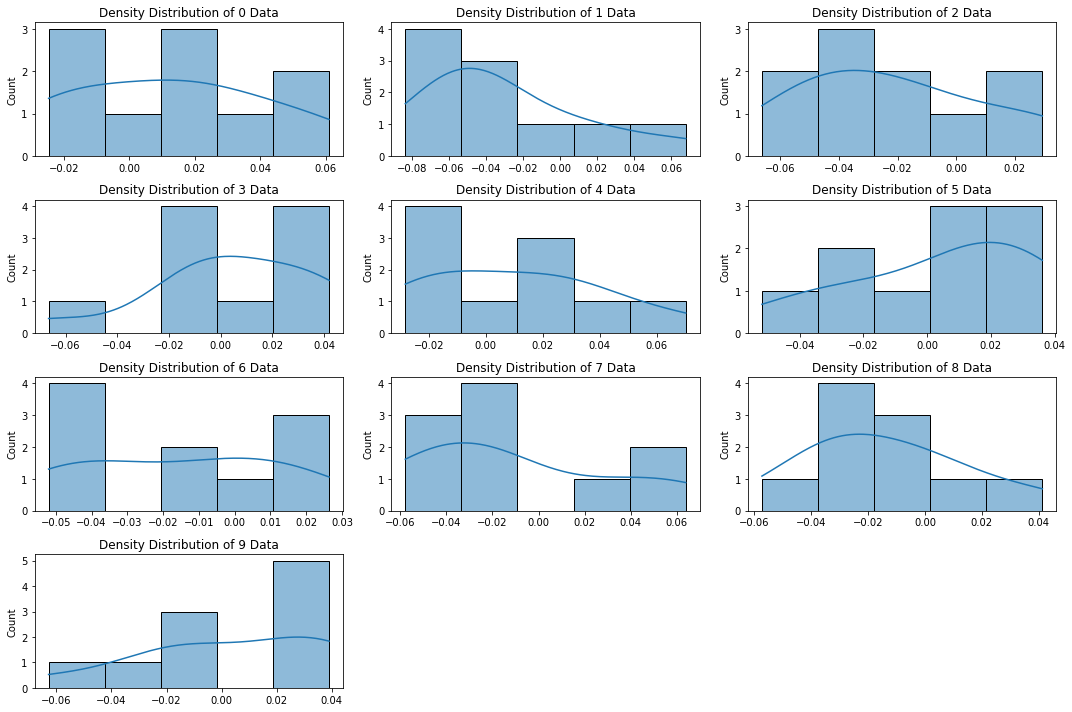

In [17]:
plt.figure(figsize=(15,10))
for i,col in enumerate(pd.DataFrame(heart_ica).columns,1):
    plt.subplot(4,3,i)
    plt.title(f"Density Distribution of {col} Data")
    sns.histplot(heart_ica[col],kde=True)
    plt.tight_layout()
    plt.plot()

<AxesSubplot:xlabel='ica-0', ylabel='ica-1'>

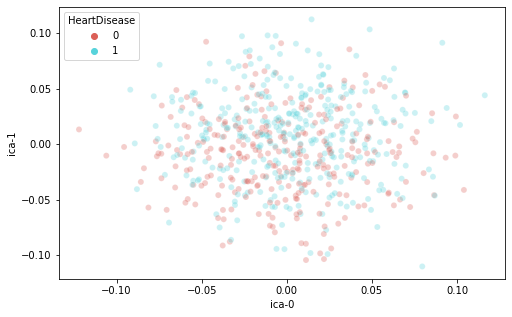

In [18]:
heart_Train.reset_index(drop=True, inplace=True)
rndperm = np.random.permutation(heart_Train.shape[0])
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="ica-0", y="ica-1",
    hue="HeartDisease",
    palette=sns.color_palette("hls", 2),
    data=heart_Train,
    legend="full",
    alpha=0.3
)

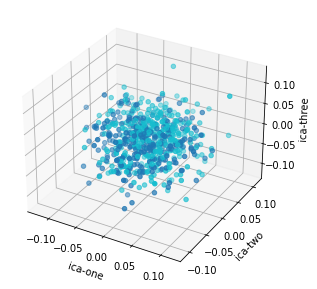

In [19]:
ax = plt.figure(figsize=(8,5)).gca(projection='3d')
ax.scatter(
    xs=heart_Train.loc[rndperm,:]["ica-0"], 
    ys=heart_Train.loc[rndperm,:]["ica-1"], 
    zs=heart_Train.loc[rndperm,:]["ica-2"], 
    c=heart_Train.loc[rndperm,:]["HeartDisease"], 
    cmap='tab10'
)
ax.set_xlabel('ica-one')
ax.set_ylabel('ica-two')
ax.set_zlabel('ica-three')
plt.show()

In [20]:
fig = px.scatter_3d(heart_Train,
                    x='ica-0',
                    y='ica-1',
                    z='ica-2',
                    color='HeartDisease',
                    title='Heart ICA 3 visualization',
#                     template='plotly_dark',
                    color_discrete_sequence=px.colors.qualitative.Antique)
fig.update_traces(marker=dict(size=2))
fig.update_layout(width=700, height=500, bargap=0.05)
fig.show()

In [21]:
# Choose the number of components that capture 85% of the variance
comp = 10
ica = FastICA(n_components=comp, random_state=42, max_iter=1000)
XH_transform = ica.fit_transform(XH_train)

XH_inverse = ica.inverse_transform(XH_transform)
mse1 = np.sum(np.square(XH_train - XH_inverse))/XH_inverse.size
print('MSE for dataset 1: ', mse1)
rc_err = mean_squared_error(XH_train, XH_inverse) 
print('MSE- ', rc_err)
print( '------ Baseline Dummy -----')
dummy_NN_RecallScore_train(XH_train, yH_train)
print( '------ Heart ICA Dummy -----')
dummy_NN_RecallScore_train(XH_transform, yH_train)

MSE for dataset 1:  Age               9.587600e-10
Sex               4.840988e-03
ChestPainType     7.807995e-05
RestingBP         2.985847e-06
Cholesterol       9.794109e-05
FastingBS         2.302079e-05
RestingECG        1.607869e-05
MaxHR             8.535386e-06
ExerciseAngina    6.719234e-03
Oldpeak           3.841141e-05
ST_Slope          4.427798e-04
dtype: float64
MSE-  0.012268055290053703
------ Baseline Dummy -----
Train Time: 0.884 seconds
Test Time: 0.003 seconds
Recall Score of NN is 93.52%
------ Heart ICA Dummy -----
Train Time: 0.797 seconds
Test Time: 0.001 seconds
Recall Score of NN is 87.89%


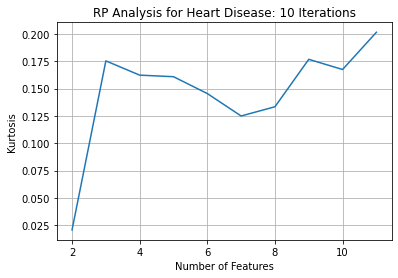

Total Number of Features: 11
Best Number of RP Components: 11
Total Time: 0.307 seconds


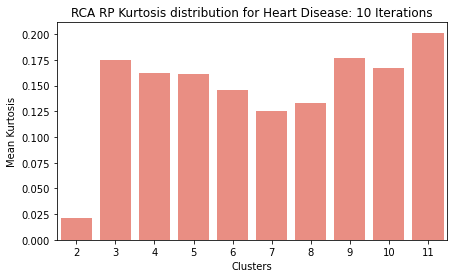

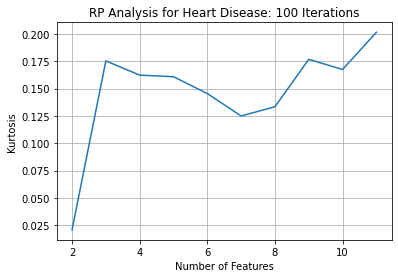

Total Number of Features: 11
Best Number of RP Components: 11
Total Time: 3.022 seconds


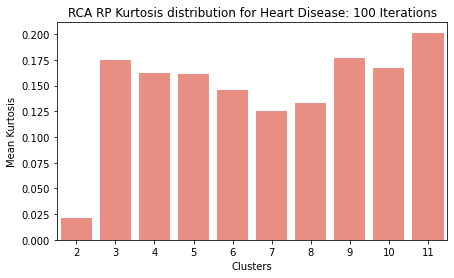

RCA Reconstruction Error:  0.041561041429260794


In [22]:
#
#RPA
#
b_rca_heart_c = calc_rp_components(XH_train, 'Heart Disease', 10)
plot_rca_meanKurtosiss(XH_train, 'Heart Disease', 10)
b_rca_heart_c = calc_rp_components(XH_train, 'Heart Disease', 100)
plot_rca_meanKurtosiss(XH_train, 'Heart Disease', 100)
#hardcoding 9
b_rca_heart = GRP(n_components=10, random_state=33).fit(XH_train)
b_rca_r_err = reconstruction_error(b_rca_heart, heartX)
print('RCA Reconstruction Error: ', b_rca_r_err)




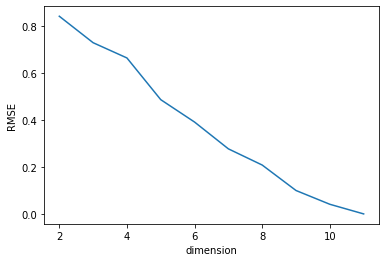

In [23]:
rmse_RCA_GAUSS(XH_train, 'Heart Disease')

In [24]:
comp = 10
grp = GRP(n_components=comp, random_state=44)
grp_result = grp.fit_transform(XH_train.values)
for i in range(comp):
    field_name = "grp-"+str(i)
    heart_Train[field_name] = grp_result[:,i]
#     wine_dataset[field_name] = grp_result[:,i]
heart_grp_9 = grp_result

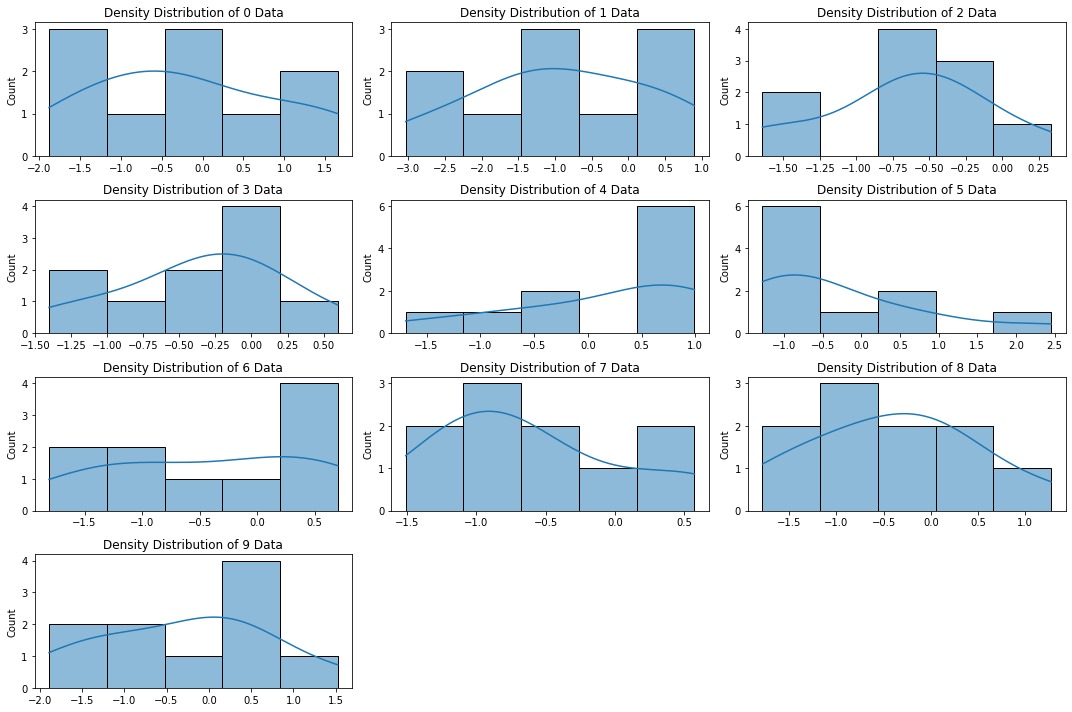

In [25]:
plt.figure(figsize=(15,10))
for i,col in enumerate(pd.DataFrame(heart_grp_9).columns,1):
    plt.subplot(4,3,i)
    plt.title(f"Density Distribution of {col} Data")
    sns.histplot(heart_grp_9[col],kde=True)
    plt.tight_layout()
    plt.plot()

<AxesSubplot:xlabel='grp-0', ylabel='grp-1'>

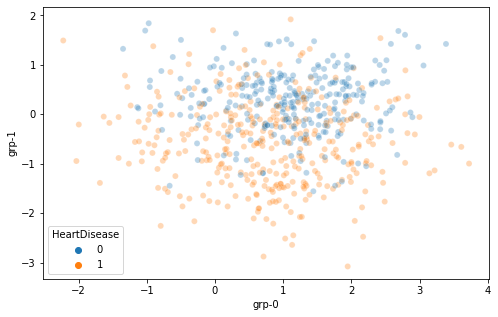

In [26]:
heart_Train.reset_index(drop=True, inplace=True)
rndperm = np.random.permutation(heart_Train.shape[0])
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="grp-0", y="grp-1",
    hue="HeartDisease",
    palette=sns.color_palette("tab10", 2),
    data=heart_Train,
    legend="full",
    alpha=0.3
)

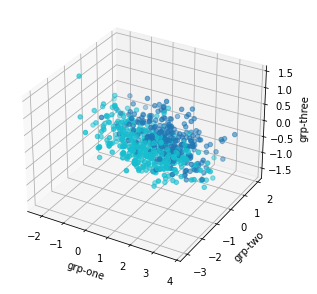

In [27]:
ax = plt.figure(figsize=(8,5)).gca(projection='3d')
ax.scatter(
    xs=heart_Train.loc[rndperm,:]["grp-0"], 
    ys=heart_Train.loc[rndperm,:]["grp-1"], 
    zs=heart_Train.loc[rndperm,:]["grp-2"], 
    c=heart_Train.loc[rndperm,:]["HeartDisease"], 
    cmap='tab10'
)
ax.set_xlabel('grp-one')
ax.set_ylabel('grp-two')
ax.set_zlabel('grp-three')
plt.show()

In [28]:
# Choose the number of components that capture 85% of the variance
comp = 10
grp = GRP(n_components=10, random_state=33).fit(XH_train)
XH_transform = grp.fit_transform(XH_train)

# XH_inverse = grp.inverse_transform(XH_transform)
# mse1 = np.sum(np.square(XH_train - XH_inverse))/XH_inverse.size
# print('MSE for dataset 1: ', mse1)
# rc_err = mean_squared_error(XH_train, XH_inverse) 
# print('MSE- ', rc_err)
    
# reconstruction
A = np.linalg.pinv(grp.components_.T)
reconstructed = np.dot(XH_transform, A)
rc_err = mean_squared_error(XH_train, reconstructed) 
print('MSE- ', rc_err)
        
print( '------ Baseline Dummy -----')
dummy_NN_RecallScore_train(XH_train, yH_train)
print( '------ Heart ICA Dummy -----')
dummy_NN_RecallScore_train(XH_transform, yH_train)

MSE-  0.04107727627512567
------ Baseline Dummy -----
Train Time: 0.875 seconds
Test Time: 0.003 seconds
Recall Score of NN is 93.52%
------ Heart ICA Dummy -----
Train Time: 0.886 seconds
Test Time: 0.001 seconds
Recall Score of NN is 88.45%


<h1> ETC DM </h1>

In [29]:
XH_train.head()

Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  \
417 -1.008848    1              0  -0.129513    -0.481182  -0.551341   
602  0.794391    1              2  -0.669935     1.795980  -0.551341   
526  1.218683    1              0   0.627078     1.351222  -0.551341   
256  0.157954    0              1  -0.129513    -0.232118  -0.551341   
442 -0.266338    1              0  -0.237597    -0.662652   1.813758   

     RestingECG     MaxHR  ExerciseAngina   Oldpeak  ST_Slope  
417           2 -0.385490               0 -0.832432         2  
602           1 -1.525138               1 -0.832432         1  
526           0 -0.935665               1  0.762331         1  
256           0  0.518368               0 -0.832432         2  
442           2 -0.464087               1  0.293283         1

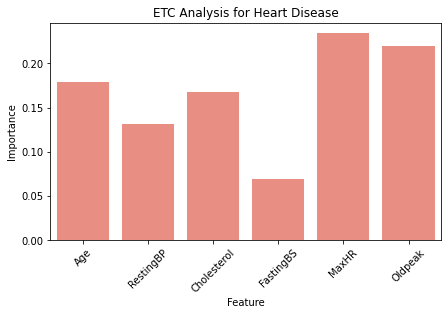

Heart Disease total features: 6
Total Time: 0.118 seconds
Selected Features
[ True False  True False  True  True]


In [30]:
backup_df = XH_train[['Sex','ChestPainType', 'RestingECG','ExerciseAngina','ST_Slope']].copy()
reduction_df = XH_train[['Age','RestingBP', 'Cholesterol','FastingBS','MaxHR','Oldpeak']].copy()
h_cols = ['Age','RestingBP', 'Cholesterol','FastingBS','MaxHR','Oldpeak']
selected_model= calc_ETC_model(reduction_df,yH_train,h_cols, "Heart Disease")
model = SelectFromModel(selected_model, prefit=True)
X_Trees = model.transform(reduction_df)
print("Selected Features")
print(model.get_support())

In [31]:
final_reduction_df = XH_train[['Age','MaxHR','Oldpeak','Sex','ChestPainType', 'RestingECG','ExerciseAngina','ST_Slope']].copy()

In [32]:
final_reduction_df.head()

Age     MaxHR   Oldpeak  Sex  ChestPainType  RestingECG  \
417 -1.008848 -0.385490 -0.832432    1              0           2   
602  0.794391 -1.525138 -0.832432    1              2           1   
526  1.218683 -0.935665  0.762331    1              0           0   
256  0.157954  0.518368 -0.832432    0              1           0   
442 -0.266338 -0.464087  0.293283    1              0           2   

     ExerciseAngina  ST_Slope  
417               0         2  
602               1         1  
526               1         1  
256               0         2  
442               1         1

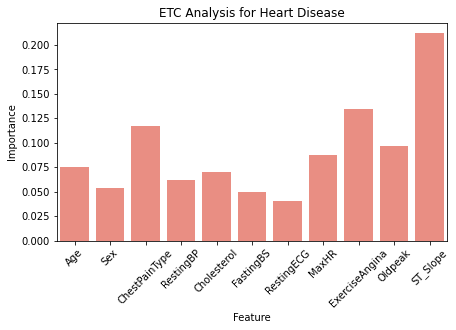

Heart Disease total features: 11
Total Time: 0.115 seconds
Selected Features
[False False  True False False False False False  True  True  True]


In [33]:
#
#ETC
#

h_cols = data_H.columns.values.tolist()[:-1]
selected_model= calc_ETC_model(XH_train,yH_train,h_cols, "Heart Disease")
model = SelectFromModel(selected_model, prefit=True)
X_Trees = model.transform(XH_train)
print("Selected Features")
print(model.get_support())

<h3>Wine Data<h3>

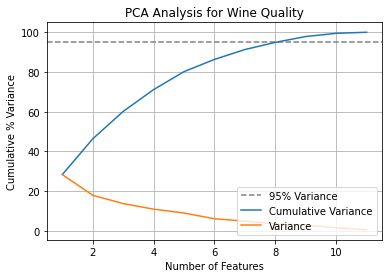

Wine Quality total features: 11
Best Number of PCA Components: 9
Total Time: 0.002 seconds
PCA Reconstruction Error:  0.021519881830716972


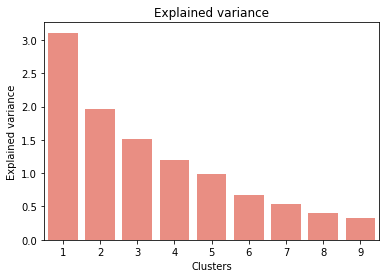

In [34]:
# PCA
b_pca_wine_c = calc_pca_components(XW_train, "Wine Quality")
b_pca_wine = PCA(n_components=b_pca_wine_c, random_state=33).fit(XW_train)
b_pca_r_err = reconstruction_error(b_pca_wine, wineX)
print('PCA Reconstruction Error: ', b_pca_r_err)
plot_explained_varaince(b_pca_wine, b_pca_wine_c)



In [35]:
wine_Train.reset_index(drop=True, inplace=True)
comp = 9
pca = PCA(n_components=comp, random_state=42)
pca_result = pca.fit_transform(XW_train)
for i in range(comp):
    field_name = "pca-"+str(i)
    wine_Train[field_name] = pca_result[:,i]
#     heart_dataset[field_name] = pca_result[:,i]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
sum(pca.explained_variance_ratio_)
wineX_pca = pca_result

Explained variation per principal component: [0.28379044 0.17981582 0.13800123 0.10981468 0.09038494 0.06155586
 0.04962039 0.03615628 0.02930427]


<AxesSubplot:xlabel='pca-0', ylabel='pca-1'>

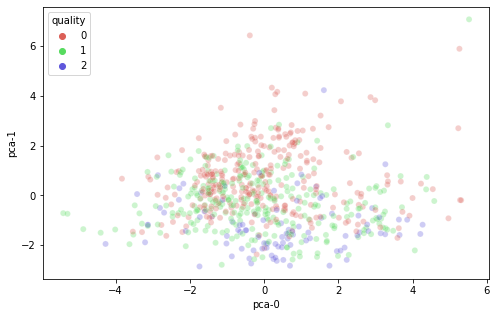

In [36]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="pca-0", y="pca-1",
    hue="quality",
    palette=sns.color_palette("hls", 3),
    data=wine_Train,
    legend="full",
    alpha=0.3
)

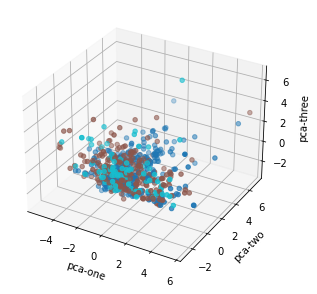

In [37]:
rndperm = np.random.permutation(wine_Train.shape[0])
ax = plt.figure(figsize=(8,5)).gca(projection='3d')
ax.scatter(
    xs=wine_Train.loc[rndperm,:]["pca-0"], 
    ys=wine_Train.loc[rndperm,:]["pca-1"], 
    zs=wine_Train.loc[rndperm,:]["pca-2"], 
    c=wine_Train.loc[rndperm,:]["quality"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [38]:
fig = px.scatter_3d(wine_Train,
                    x='pca-0',
                    y='pca-1',
                    z='pca-2',
                    color='quality',
                    title='Wine PCA 3 visualization'
#                     template='plotly_dark',
                    )
fig.update_traces(marker=dict(size=2))
fig.update_layout(width=700, height=500, bargap=0.05)
fig.show()

In [39]:

# Choose the number of components that capture 85% of the variance
n1 = 9
# Transform the data
wine_pca = PCA(n_components=n1)
XW_transform = wine_pca.fit_transform(XW_train)

XW_inverse = wine_pca.inverse_transform(XW_transform)
mse1 = np.sum(np.square(XW_train - XW_inverse))/XW_inverse.size
print('MSE for dataset 1: ', mse1)

rc_err = mean_squared_error(XW_train, XW_inverse) 
print('MSE- ', rc_err)
    

print( '------ Baseline Dummy -----')
dummy_NN_f1Score_train(XW_train, yW_train)
print( '------ Wine PCA Dummy -----')
dummy_NN_f1Score_train(XW_transform, yW_train)

MSE for dataset 1:  fixed acidity           0.003334
volatile acidity        0.002262
citric acid             0.006477
residual sugar          0.000243
chlorides               0.000683
free sulfur dioxide     0.001022
total sulfur dioxide    0.002336
density                 0.002486
pH                      0.000624
sulphates               0.000046
alcohol                 0.001926
dtype: float64
MSE-  0.021439298960929363
------ Baseline Dummy -----
Train Time: 0.570 seconds
Test Time: 0.003 seconds
f1_micro Score of NN is 74.01%
------ Wine PCA Dummy -----
Train Time: 0.631 seconds
Test Time: 0.002 seconds
f1_micro Score of NN is 72.26%


[1.1866648996557285, 2.2473260322752564, 5.918326503452887, 9.51642868009078, 9.07473959368866, 9.76734131152345, 9.85477697731291, 10.08446610294577, 9.266422222791665, 9.750663874366069]


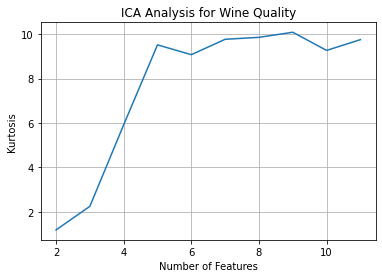

Total Number of Features: 11
Best Number of ICA Components: 8
Total Time: 0.090 seconds
ICA Reconstruction Error:  0.02151988183071697


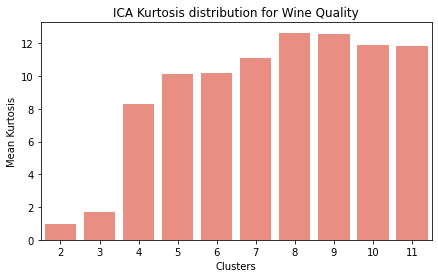

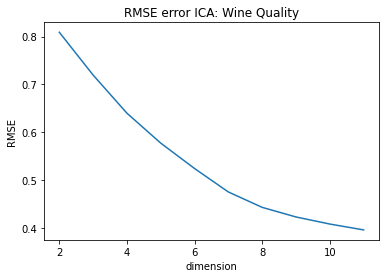

In [40]:
# ICA
b_ica_wine_c = calc_ica_components(XW_train, "Wine Quality")
b_ica_wine = FastICA(n_components=9, random_state=33).fit(XW_train)
b_ica_r_err = reconstruction_error(b_ica_wine, wineX)
print('ICA Reconstruction Error: ', b_ica_r_err)
plot_ica_meanKurtosiss(wineX, "Wine Quality")

rmse_ICA(XH_train, "Wine Quality")



In [41]:
# Choose the number of components that capture 85% of the variance
comp = 8
ica = FastICA(n_components=comp, random_state=33, max_iter=1000)
XW_transform = ica.fit_transform(XW_train)

XW_inverse = ica.inverse_transform(XW_transform)
mse1 = np.sum(np.square(XW_train - XW_inverse))/XW_inverse.size
print('MSE for dataset 1: ', mse1)

MSE for dataset 1:  fixed acidity           0.004649
volatile acidity        0.002795
citric acid             0.008866
residual sugar          0.000319
chlorides               0.001973
free sulfur dioxide     0.012781
total sulfur dioxide    0.012861
density                 0.002834
pH                      0.000632
sulphates               0.000772
alcohol                 0.002104
dtype: float64


In [42]:
comp = 9
ica = FastICA(n_components=comp, random_state=33, max_iter=1000)
ica_result = ica.fit_transform(XW_train.values)
for i in range(comp):
    field_name = "ica-"+str(i)
    wine_Train[field_name] = ica_result[:,i]
wine_ica = ica_result

<AxesSubplot:xlabel='ica-0', ylabel='ica-1'>

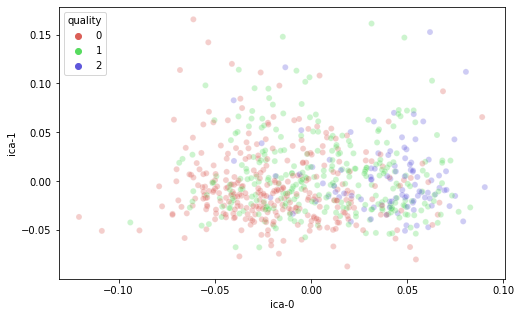

In [43]:
rndperm = np.random.permutation(wine_Train.shape[0])
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="ica-0", y="ica-1",
    hue="quality",
    palette=sns.color_palette("hls", 3),
    data=wine_Train,
    legend="full",
    alpha=0.3
)

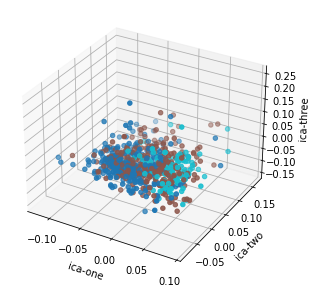

In [44]:
ax = plt.figure(figsize=(8,5)).gca(projection='3d')
ax.scatter(
    xs=wine_Train.loc[rndperm,:]["ica-0"], 
    ys=wine_Train.loc[rndperm,:]["ica-1"], 
    zs=wine_Train.loc[rndperm,:]["ica-2"], 
    c=wine_Train.loc[rndperm,:]["quality"], 
    cmap='tab10'
)
ax.set_xlabel('ica-one')
ax.set_ylabel('ica-two')
ax.set_zlabel('ica-three')
plt.show()

In [45]:
fig = px.scatter_3d(wine_Train,
                    x='ica-0',
                    y='ica-1',
                    z='ica-2',
                    color='quality',
                    title='Wine ICA 3 visualization'
#                     template='plotly_dark',
                    )
fig.update_traces(marker=dict(size=2))
fig.update_layout(width=700, height=500, bargap=0.05)
fig.show()

In [46]:
# Choose the number of components that capture 85% of the variance
comp = 8
ica = FastICA(n_components=comp, random_state=33, max_iter=1000)
XW_transform = ica.fit_transform(XW_train)

XW_inverse = ica.inverse_transform(XW_transform)
mse1 = np.sum(np.square(XW_train - XW_inverse))/XW_inverse.size
print('MSE for dataset 1: ', mse1)

rc_err = mean_squared_error(XW_train, XW_inverse) 
print('MSE- ', rc_err)
    
print( '------ Baseline Dummy -----')
dummy_NN_f1Score_train(XW_train, yW_train)
print( '------ Wine ICA Dummy -----')
dummy_NN_f1Score_train(XW_transform, yW_train)

MSE for dataset 1:  fixed acidity           0.004649
volatile acidity        0.002795
citric acid             0.008866
residual sugar          0.000319
chlorides               0.001973
free sulfur dioxide     0.012781
total sulfur dioxide    0.012861
density                 0.002834
pH                      0.000632
sulphates               0.000772
alcohol                 0.002104
dtype: float64
MSE-  0.05058478595669676
------ Baseline Dummy -----
Train Time: 0.667 seconds
Test Time: 0.002 seconds
f1_micro Score of NN is 74.01%
------ Wine ICA Dummy -----
Train Time: 0.569 seconds
Test Time: 0.001 seconds
f1_micro Score of NN is 63.21%


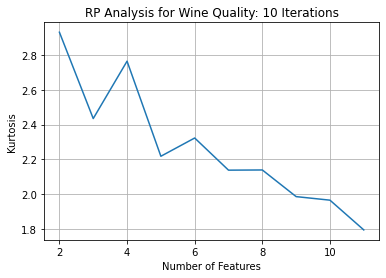

Total Number of Features: 11
Best Number of RP Components: 2
Total Time: 0.322 seconds


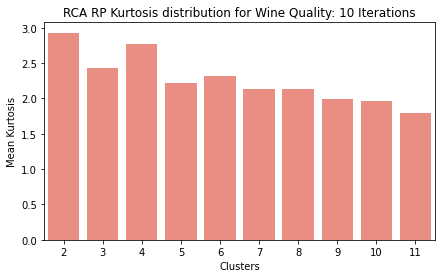

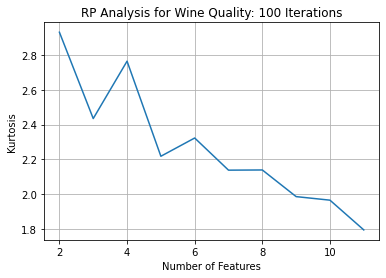

Total Number of Features: 11
Best Number of RP Components: 2
Total Time: 2.986 seconds


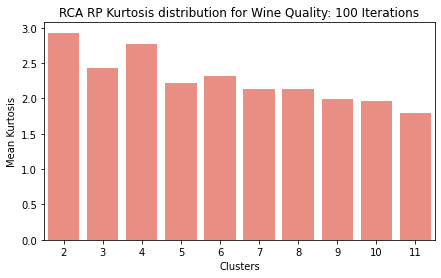

In [47]:
#RPA
b_rca_wine_c = calc_rp_components(XW_train, 'Wine Quality', 10)
plot_rca_meanKurtosiss(XW_train, 'Wine Quality', 10)
b_rca_wine_c= calc_rp_components(XW_train, 'Wine Quality', 100)
plot_rca_meanKurtosiss(XW_train, 'Wine Quality', 100)
#hardocing 9


In [48]:
b_rca_wine = GRP(n_components=10, random_state=33).fit(XW_train)
b_rca_r_err = reconstruction_error(b_rca_wine, wineX)
print('RCA Reconstruction Error: ', b_rca_r_err)

RCA Reconstruction Error:  0.10392676653933731


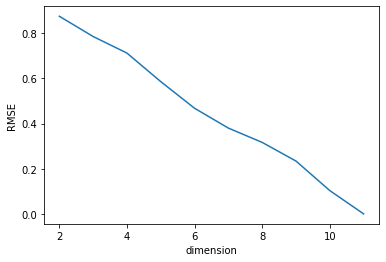

In [49]:
rmse_RCA_GAUSS(XW_train, 'Wine Quality')

<AxesSubplot:xlabel='grp-0', ylabel='grp-1'>

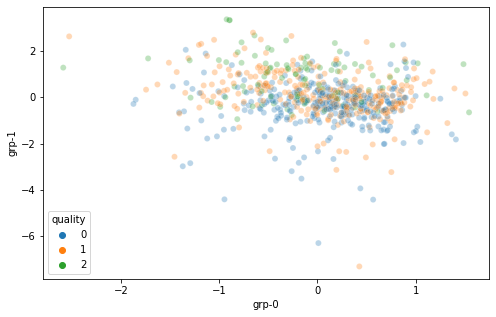

In [50]:
comp = 10
grp = GRP(n_components=comp, random_state=33)
grp_result = grp.fit_transform(XW_train.values)
for i in range(comp):
    field_name = "grp-"+str(i)
    wine_Train[field_name] = grp_result[:,i]
#     wine_dataset[field_name] = grp_result[:,i]
wine_grp_4 = grp_result

rndperm = np.random.permutation(wine_Train.shape[0])
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="grp-0", y="grp-1",
    hue="quality",
    palette=sns.color_palette("tab10", 3),
    data=wine_Train,
    legend="full",
    alpha=0.3
)

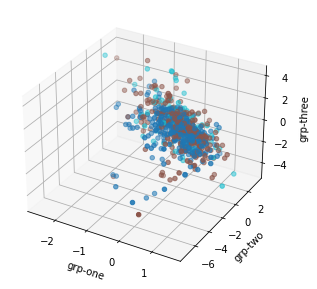

In [51]:
ax = plt.figure(figsize=(8,5)).gca(projection='3d')
ax.scatter(
    xs=wine_Train.loc[rndperm,:]["grp-0"], 
    ys=wine_Train.loc[rndperm,:]["grp-1"], 
    zs=wine_Train.loc[rndperm,:]["grp-2"], 
    c=wine_Train.loc[rndperm,:]["quality"], 
    cmap='tab10'
)
ax.set_xlabel('grp-one')
ax.set_ylabel('grp-two')
ax.set_zlabel('grp-three')
plt.show()

In [52]:
b_rca_heart = GRP(n_components=10, random_state=33).fit(XW_train)
b_rca_r_err = reconstruction_error(b_rca_heart, wineX)
print('RCA Reconstruction Error: ', b_rca_r_err)

RCA Reconstruction Error:  0.10392676653933731


In [53]:
# Choose the number of components that capture 85% of the variance
comp = 10
grp = GRP(n_components=comp, random_state=33).fit(XW_train)
XW_transform = grp.fit_transform(XW_train)

# XH_inverse = grp.inverse_transform(XH_transform)
# mse1 = np.sum(np.square(XH_train - XH_inverse))/XH_inverse.size
# print('MSE for dataset 1: ', mse1)
# rc_err = mean_squared_error(XH_train, XH_inverse) 
# print('MSE- ', rc_err)
    
# reconstruction
A = np.linalg.pinv(grp.components_.T)
reconstructed = np.dot(XW_transform, A)
rc_err = mean_squared_error(XW_train, reconstructed) 
print('MSE- ', rc_err)
        
print( '------ Baseline Dummy -----')
dummy_NN_f1Score_train(XW_train, yW_train)
print( '------ Wine RP Dummy -----')
dummy_NN_f1Score_train(XW_transform, yW_train)

MSE-  0.10314171675286908
------ Baseline Dummy -----
Train Time: 0.547 seconds
Test Time: 0.002 seconds
f1_micro Score of NN is 74.01%
------ Wine RP Dummy -----
Train Time: 0.556 seconds
Test Time: 0.002 seconds
f1_micro Score of NN is 69.93%


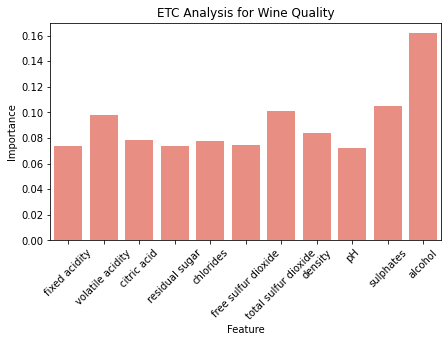

Wine Quality total features: 11
Total Time: 0.151 seconds
Selected Features
[False  True False False False False  True False False  True  True]


In [54]:

h_cols = data_W.columns.values.tolist()[:-1]
selected_model= calc_ETC_model(XW_train,yW_train,h_cols, "Wine Quality")
model = SelectFromModel(selected_model, prefit=True)
X_Trees = model.transform(XW_train)
print("Selected Features")
print(model.get_support())

In [55]:
# etc = ExtraTreesClassifier(n_estimators = 100)
# etc = etc.fit(X,y)
# print(etc.feature_importances_)
# model = SelectFromModel(etc, prefit=True)
# X_Trees = model.transform(X)
# print(model.get_support())
# X_Trees_train, X_Trees_test, y_Trees_train, y_Trees_test = train_test_split(X_Trees, y, test_size=0.3, random_state=33)